In [7]:
from PIL import Image
from PIL import ImageFilter
from PIL import ImageChops
from PIL import ImageFont
from PIL import ImageDraw
from PIL import ImageTk
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as tvt
import torchvision
import os
import PIL
from PIL import Image, ImageDraw
import random
import glob
from scipy.stats import wasserstein_distance

## Theory: understand Data normalization

- On slide 26, we use per batch pixel_value_max to project from [0, images.max()] to [0, 1], where images.max() = 255

- On slide 28, we apply tvt.ToTensor per image. However, tvt.ToTensor project images from [0, 255] to [0, 1] regardless the max pixel value. 

- That is why we get the same result for the above two implementations

In [8]:
# Theory
seed = 0
torch.manual_seed(seed)
images = torch.randint(0,256,(4,3,5,9)).type(torch.uint8)
print(images[0])
print(images.shape)

tensor([[[172,  47, 117, 192,  67, 251, 195, 103,   9],
         [211,  21, 242,  36,  87,  70, 216,  88, 140],
         [ 58, 193, 230,  39,  87, 174,  88,  81, 165],
         [ 25,  77,  72,   9, 148, 115, 208, 243, 197],
         [254,  79, 175, 192,  82,  99, 216, 177, 243]],

        [[ 29, 147, 147, 142, 167,  32, 193,   9, 185],
         [127,  32,  31, 202, 244, 151, 163, 254, 203],
         [114, 183,  28,  34, 128, 128, 164,  53, 133],
         [ 38, 232, 244,  17,  79, 132, 105,  42, 186],
         [ 31, 120,   1,  65, 231, 169,  57,  35, 102]],

        [[119,  11, 174,  82,  91, 128, 142,  99,  53],
         [140, 121, 170,  84, 203,  68,   6, 196,  47],
         [127, 244, 131, 204, 100, 180, 232,  78, 143],
         [148, 227, 186,  23, 207, 141, 117,  85,  48],
         [ 49,  69, 169, 163, 192,  95, 197,  94,   0]]], dtype=torch.uint8)
torch.Size([4, 3, 5, 9])


In [15]:
print(images.max())

max_pixel_location = (images == images.max()).nonzero()
print(max_pixel_location)

min_pixel_location = (images == images.min()).nonzero()
print(min_pixel_location)

tensor(255, dtype=torch.uint8)
tensor([[2, 1, 3, 3]])
tensor([[0, 2, 4, 8],
        [1, 0, 1, 6],
        [2, 1, 3, 5],
        [3, 1, 2, 6]])


In [17]:
image_scaled = images/images.max().float()
image_scaled[0]

tensor([[[0.6745, 0.1843, 0.4588, 0.7529, 0.2627, 0.9843, 0.7647, 0.4039,
          0.0353],
         [0.8275, 0.0824, 0.9490, 0.1412, 0.3412, 0.2745, 0.8471, 0.3451,
          0.5490],
         [0.2275, 0.7569, 0.9020, 0.1529, 0.3412, 0.6824, 0.3451, 0.3176,
          0.6471],
         [0.0980, 0.3020, 0.2824, 0.0353, 0.5804, 0.4510, 0.8157, 0.9529,
          0.7725],
         [0.9961, 0.3098, 0.6863, 0.7529, 0.3216, 0.3882, 0.8471, 0.6941,
          0.9529]],

        [[0.1137, 0.5765, 0.5765, 0.5569, 0.6549, 0.1255, 0.7569, 0.0353,
          0.7255],
         [0.4980, 0.1255, 0.1216, 0.7922, 0.9569, 0.5922, 0.6392, 0.9961,
          0.7961],
         [0.4471, 0.7176, 0.1098, 0.1333, 0.5020, 0.5020, 0.6431, 0.2078,
          0.5216],
         [0.1490, 0.9098, 0.9569, 0.0667, 0.3098, 0.5176, 0.4118, 0.1647,
          0.7294],
         [0.1216, 0.4706, 0.0039, 0.2549, 0.9059, 0.6627, 0.2235, 0.1373,
          0.4000]],

        [[0.4667, 0.0431, 0.6824, 0.3216, 0.3569, 0.5020, 0.5569, 

In [30]:
image_scaled_2 = torch.zeros_like(images).float()

for i in range(image_scaled_2.shape[0]):
    image_scaled_2[i] = tvt.ToTensor()(np.transpose(images[i].numpy(), (1,2,0)))
    
image_scaled_2[0]

tensor([[[0.6745, 0.1843, 0.4588, 0.7529, 0.2627, 0.9843, 0.7647, 0.4039,
          0.0353],
         [0.8275, 0.0824, 0.9490, 0.1412, 0.3412, 0.2745, 0.8471, 0.3451,
          0.5490],
         [0.2275, 0.7569, 0.9020, 0.1529, 0.3412, 0.6824, 0.3451, 0.3176,
          0.6471],
         [0.0980, 0.3020, 0.2824, 0.0353, 0.5804, 0.4510, 0.8157, 0.9529,
          0.7725],
         [0.9961, 0.3098, 0.6863, 0.7529, 0.3216, 0.3882, 0.8471, 0.6941,
          0.9529]],

        [[0.1137, 0.5765, 0.5765, 0.5569, 0.6549, 0.1255, 0.7569, 0.0353,
          0.7255],
         [0.4980, 0.1255, 0.1216, 0.7922, 0.9569, 0.5922, 0.6392, 0.9961,
          0.7961],
         [0.4471, 0.7176, 0.1098, 0.1333, 0.5020, 0.5020, 0.6431, 0.2078,
          0.5216],
         [0.1490, 0.9098, 0.9569, 0.0667, 0.3098, 0.5176, 0.4118, 0.1647,
          0.7294],
         [0.1216, 0.4706, 0.0039, 0.2549, 0.9059, 0.6627, 0.2235, 0.1373,
          0.4000]],

        [[0.4667, 0.0431, 0.6824, 0.3216, 0.3569, 0.5020, 0.5569, 

## 3.1 Set up conda environment

- PLease see the attached 'environment.yml'

## 3.2 Be familiar with torchvision.transform


### Stop sign images from two angle and restore the distortion with tvt.transform

#### Projective
- Here I locate four correspondance key points from both the images. 
- Based on this, we can calculate the projective homography and project image from the distorted image to the original image. 
- For the homework, I applied torchvision.transforms.functional.perspective.

#### Affine
- Implement RandomAffine for 100 times and find the Affine transformed image with smallest wasserstein_distance to the original image

#### Conclusion: Projective works better than Affine, because it is a more general way of transformation.

In [3]:
os.chdir('*/hw2')
os.getcwd()
image1_file = 'IMG_0214.jpg'
image2_file = 'IMG_0215.jpg'

In [4]:
image1 = Image.open(image1_file)
image1 = image1.rotate(-90, expand = 1)

image2 = Image.open(image2_file)
image2 = image2.rotate(-90, expand = 1)

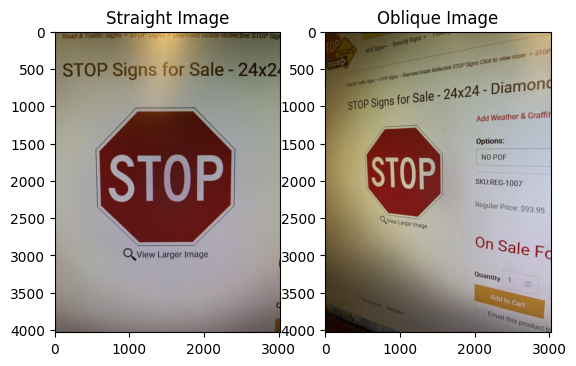

In [6]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image1)
axarr[1].imshow(image2)

axarr[0].title.set_text('Straight Image')
axarr[1].title.set_text('Oblique Image')

### Projective

In [41]:
# [top-left, top-right, bottom-right, bottom-left] 
Origin = [[662,1601] , [2430,1616], [2406,2331],  [673, 2325]]
Aim = [[3024-2464,1656],  [3024-1480,1660],[3024-1476,2174], [3024-2438,2102]]

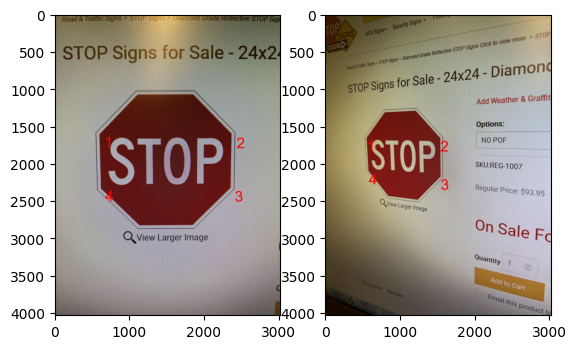

In [45]:
# indicate the four points in each image
im3 = image1.copy()
draw = ImageDraw.Draw(im3)
#draw.rectangle((100, 1000, 900, 100), fill=(0, 192, 192), outline=(255, 255, 255))
font = ImageFont.truetype("arial.ttf", 200)
draw.text((Origin[0][0],Origin[0][1]), '1', align ="left",fill=(255, 0, 0), font = font) 
draw.text((Origin[1][0],Origin[1][1]), '2', align ="left",fill=(255, 0, 0), font = font) 
draw.text((Origin[2][0],Origin[2][1]), '3', align ="left",fill=(255, 0, 0), font = font) 
draw.text((Origin[3][0],Origin[3][1]), '4', align ="left",fill=(255, 0, 0), font = font) 

im4 = image2.copy()
draw1 = ImageDraw.Draw(im4)
#draw.rectangle((100, 1000, 900, 100), fill=(0, 192, 192), outline=(255, 255, 255))
font = ImageFont.truetype("arial.ttf", 200)
draw1.text((Aim[0][0],Aim[0][1]), '1', align ="left",fill=(255, 0, 0), font = font) 
draw1.text((Aim[1][0],Aim[1][1]), '2', align ="left",fill=(255, 0, 0), font = font) 
draw1.text((Aim[2][0],Aim[2][1]), '3', align ="left",fill=(255, 0, 0), font = font) 
draw1.text((Aim[3][0],Aim[3][1]), '4', align ="left",fill=(255, 0, 0), font = font) 

f, axarr = plt.subplots(1,2)
axarr[0].imshow(im3)
axarr[1].imshow(im4)

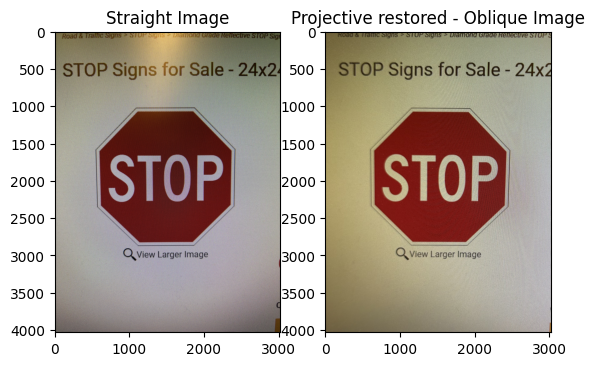

In [105]:
# transform the image with perspective transformation
image2_perpective = torchvision.transforms.functional.perspective(image2, Aim, Origin)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(image1)
axarr[1].imshow(image2_perpective)
axarr[0].title.set_text('Straight Image')
axarr[1].title.set_text('Projective restored - Oblique Image')

### Affine

In [125]:
Transform = tvt.Compose([tvt.ToTensor(),
                    tvt.RandomAffine(5, translate=(0.3,0.3), scale= (1.8, 2.1), shear=0.1)])

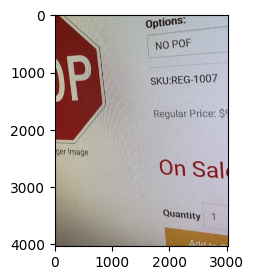

In [124]:
im_T = tvt.functional.to_pil_image(Transform(image2))

# one example
plt.figure(figsize=(4, 3))
plt.imshow(im_T)

In [139]:
# distance between two images
def hist_distance(im1, im2):
    # histogram
    hist_Tensor_1 = torch.zeros(3, num_bins, dtype=torch.float)
    hist_Tensor_2 = torch.zeros(3, num_bins, dtype=torch.float)
    
    color_1 = [im1[ch] for ch in range(3)]
    color_2 = [im2[ch] for ch in range(3)]
    
    hists_1 = [torch.histc(color_1[ch],bins=num_bins,min=-3.0,max=3.0) for ch in range(3)] ## (12)
    hists_1 = [hists_1[ch].div(hists_1[ch].sum()) for ch in range(3)] ## (13)
    hists_2 = [torch.histc(color_2[ch],bins=num_bins,min=-3.0,max=3.0) for ch in range(3)] ## (14)
    hists_2 = [hists_2[ch].div(hists_2[ch].sum()) for ch in range(3)]

    #scipy.stats.wasserstein_distance(u_values, v_values, u_weights=None, v_weights=None)[source]
    Dist = wasserstein_distance(torch.squeeze(hists_1[2]).cpu().numpy(),
                                     torch.squeeze(hists_2[2]).cpu().numpy())
#     Dist = 0
#     for ch in range(1):
#         Dist += wasserstein_distance(torch.squeeze(hists_1[ch]).cpu().numpy(),
#                                      torch.squeeze(hists_2[ch]).cpu().numpy())
    return Dist

# hist_distance(im1,im2)

In [140]:
im1_tensor = tvt.ToTensor()(image1)
im2_tensor = tvt.ToTensor()(image2)
im2_Affine_tensor = Transform(image2)
#Transform(image2)

print('Original Distnace ->', hist_distance(im1_tensor,im2_tensor))

# hist_distance(im1_tensor,im2_Affine_tensor)

Min = 1
im2_Affine_best = torch.clone(im2_tensor)
for i in range(100):
    im2_Affine_tensor = Transform(image2)
    dist = hist_distance(im1_tensor,im2_Affine_tensor)
    if dist < Min:
        im2_Affine_best = torch.clone(im2_Affine_tensor)
        Min = dist
#         plt.figure()
#         plt.imshow(tvt.functional.to_pil_image(im2_Affine_best))
#     Min = min(Min, dist)
#         print(i, Min)

print('Min Distnace ->', Min)

Original Distnace -> 0.0014847159385681149
Min Distnace -> 0.0003883808851242065


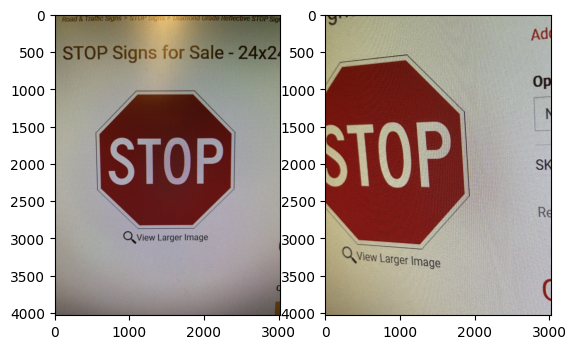

In [138]:
im_A = tvt.functional.to_pil_image(im2_Affine_best)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image1)
axarr[1].imshow(im_A)

## 3.3 Create my own Dataset Class

- I choose to RandomAffine to transform the images of 'Dog+Cat'. 
- The possible affine transformation include 'rotate','translate', 'scale','shear'. They are four possible distortion that the image can be depends on the angle between the camera and dog, the relative position and separation betweent the camera and dog.

In [50]:
class MyDataset(torch.utils.data.Dataset):
#class MyDataset(torch.utils.data.IterableDataset):
#     def __main__(self):
    
    def __init__(self, root):
        # obtain meta information, e.g. list of file names
        super(MyDataset).__init__()
        self.root = root
        os.chdir(self.root)
        self.files = glob.glob("*.jpg")
        # Initialize data augmentation transformation, etc.
        # self.Random_transform = tvt.RandomAffine(90, translate=(0.3,0.3), scale= (0.8, 1.2), shear=None)
        self.Random_transform = tvt.Compose([tvt.ToTensor(),
                                             tvt.RandomAffine(90, translate=(0.3,0.3), scale= (0.8, 1.2), shear=None),
                                             tvt.Resize([256,256])])
                                             #tvt.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    def __len__(self):
        # return total num of images
        return len(self.files)
    
    def __getitem__(self, index):
        # Read an image at index and perform augmentations
        index = index%10
        path = os.path.join(self.root, self.files[index])
        image = Image.open(path)
        # return the tuple: augmented tensor, integer label
        image_aug = self.Random_transform(image)
        
#         return torch.rand((3,256,256)), random.randint(0,10)
        return image_aug, random.randint(0,10)
    
    def origin_pil(self, index):
        # read an image at index
        index = index%10
        path = os.path.join(self.root, self.files[index])
        image = Image.open(path)
        
        return image
    
    def aug_pil(self, index):
        # return an augmented image at index
        index = index%10
        im_tensor = my_dataset[index][0]
        image = tvt.functional.to_pil_image(im_tensor)
        
        return image
        
# Create class
my_dataset = MyDataset('*/DogCat')

print(len(my_dataset))

# getitem
index = 5
print(my_dataset[index][0].shape, my_dataset[index][1])

10
torch.Size([3, 256, 256]) 10


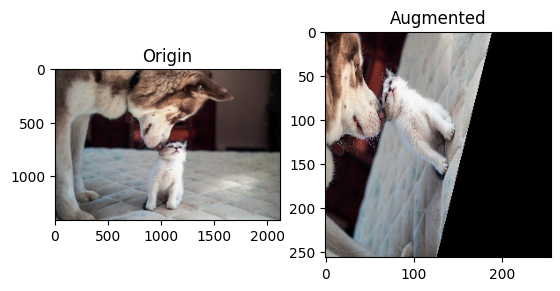

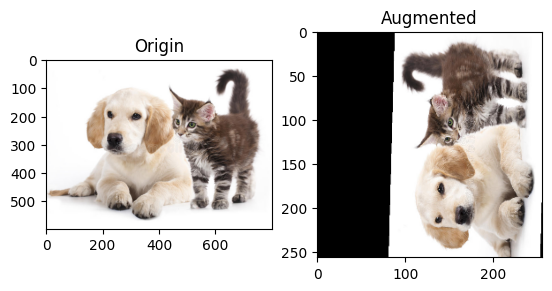

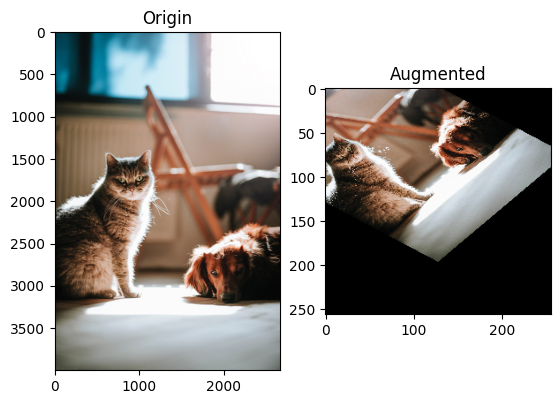

In [52]:
for i in range(3):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(my_dataset.origin_pil(2*i))
    axarr[1].imshow(my_dataset.aug_pil(2*i))

    axarr[0].title.set_text('Origin')
    axarr[1].title.set_text('Augmented')

## 3.4 Generate Data in Parallel

### Summary of the run time vs. num_workers and batch_size (Google Colab)

##### As a reference, the runtime for my_dataset*1000 on colab is 395 s.

 | |  num_workers = 1 | num_workers = 2   | num_workers = 4  |
|---:|:-----------:|:------:|:------:|
| batch_size = 4 |  243 s    | 134 s   | 167 s     |
| batch_size = 7 |  128 s    | 83 s   | 96 s     |
| batch_size = 10 | 119 s    | 80 s  | 87 s    |

#### Note: the reason why I get longer runtime for num_workers = 4, is because colab's limit.

#### Conclusion: The runtime decreases with larger num_workers and larger batch_size

In [53]:
kwargs = {'batch_size': 4,
          'shuffle': True,
          'num_workers':0,
          'drop_last': True}

# def main():
my_dataloader = torch.utils.data.DataLoader(dataset = my_dataset, **kwargs)
Iterator = iter(my_dataloader)
next(Iterator)

[tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.00

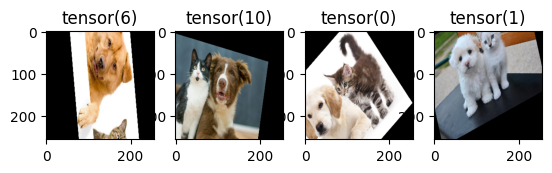

In [55]:
Iteration = iter(my_dataloader)
DATA = next(Iteration)

f, axarr = plt.subplots(1,4)

for i in range(4):    
    im_tensor = DATA[0][i] 
    image = tvt.functional.to_pil_image(im_tensor)
    
    axarr[i].imshow(image)
    axarr[i].title.set_text(DATA[1][i])

In [56]:
# reduce the size of the image to speed up the process
class MyDataset(torch.utils.data.Dataset):
#class MyDataset(torch.utils.data.IterableDataset):
#     def __main__(self):
    
    def __init__(self, root):
        # obtain meta information, e.g. list of file names
        super(MyDataset).__init__()
        self.root = root
        os.chdir(self.root)
        self.files = glob.glob("*.jpg")
        # Initialize data augmentation transformation, etc.
        # self.Random_transform = tvt.RandomAffine(90, translate=(0.3,0.3), scale= (0.8, 1.2), shear=None)
        self.Random_transform = tvt.Compose([tvt.ToTensor(),
                                             tvt.RandomAffine(90, translate=(0.3,0.3), scale= (0.8, 1.2), shear=None),
                                             tvt.Resize([64,64])])
                                             #tvt.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    def __len__(self):
        # return total num of images
        return len(self.files)
    
    def __getitem__(self, index):
        # Read an image at index and perform augmentations
        index = index%10
        path = os.path.join(self.root, self.files[index])
        image = Image.open(path)
        # return the tuple: augmented tensor, integer label
        image_aug = self.Random_transform(image)
        
#         return torch.rand((3,256,256)), random.randint(0,10)
        return image_aug, random.randint(0,10)
    
    def origin_pil(self, index):
        # read an image at index
        index = index%10
        path = os.path.join(self.root, self.files[index])
        image = Image.open(path)
        
        return image
    
    def aug_pil(self, index):
        # return an augmented image at index
        index = index%10
        im_tensor = my_dataset[index][0]
        image = tvt.functional.to_pil_image(im_tensor)
        
        return image

In [ ]:
# Time my_dataset[index] for 1000 times

# Create class
my_dataset = MyDataset('/content/drive/MyDrive/DL/DogCat')

# getitem
index = 5

time1 = time.time()
for i in range(1000):
    next(iter(my_dataset))
time2 = time.time()

time2 - time1

In [ ]:
# Time my_dataloader with different batch_number and num_workers
for num_workers in [1, 2, 4]:
    for batch_size in [4,7,10]:
        kwargs = {'batch_size': batch_size,
              'shuffle': True,
              'num_workers':num_workers,
              'drop_last': True}

        my_dataloader = torch.utils.data.DataLoader(dataset = my_dataset, **kwargs)

        time1 = time.time()
        for i in range(int(1000/batch_size)):
            next(iter(my_dataloader))
        time2 = time.time()

        print('num_workers = ',num_workers, 'batch_size=', batch_size, 'Time = ', time2 - time1)